In [1]:
# NB: per eseguire questo notebook come file Python, scegliere il menù "File -> Download as -> Python (.py)" .
# Da Canopy, scommentando questa istruzione si hanno i grafici nella console e non in finestre aggiuntive:
#get_ipython().magic(u'matplotlib inline')
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import _pickle as cPickle
import numpy.matlib as npmat
from scipy.sparse import *
from scipy.sparse.linalg import *

In [2]:
def dati_veri_dominio(corrosione=False):
  if not corrosione:
    Lungh = 5.
    n = 50
  else:
    Lungh = 2. # il dominio effettivo si riduce
    n = 20
  #endif
  Dx = Lungh/n  # passo di discretizzazione nello spazio
  return Lungh,n,Dx

In [3]:
def g0(n, Dx):
  # supponiamo che ci sia temperatura uniforme pari a 20 gradi
  T0 = 20.0 * np.ones(n+1)
  return T0

In [4]:
def f0(t): # forzante di tipo "flash" applicata al nodo 0
  t = t * 5e-04
  W = 6.6296e+006
  sig = 0.010
  Q = (W*t) * np.exp(-np.sqrt(t)/sig)
  return Q

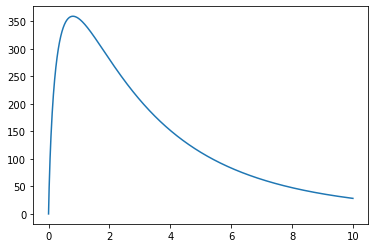

In [5]:
t = np.arange(0.0,10.0,0.01)
plt.figure(1); plt.plot(t,f0(t)); plt.show()

In [6]:
def calore_1d_fd(Lungh,n,Dx,N,eulero):
  # Approssimazione del seguente problema:
  # Dato (t,x) in [t0, tf] x [0,L], con L variabile, sia h il passo temporale
  # di discretizzazione di [t0, tf] e Dx il passo di [0,L].
  # equazione del calore: T=T(t,x) temperatura in [t0, tf] x [0,L]
  # dT/dt - c (d^2)T/d (x^2)=0
  # dT/dx(t,0)=f0(t), forzante(flash) nota
  # dT/dx (t,L)=0, condizioni di Neumnann omogenee
  # T(t0,x)=g0(x), condizioni iniziali note
  # problema discretizzato nello spazio: Ti(t)=T(t,xi), xi=i*Dx;
  # T'(t)=c A T(t)+b(t), T(t)=[T0(t),T1(t),...,Tn(t)]', b(t)=[f0(t), 0,...,0]' ; (ODE)
  # T(t0)=g0 <=> [T0(t0),T1(t0),...,Tn-1(t0)]' = [g0(x0),g0(x1),...,g0(xn-1),g0(xn)]';
  c = 1.
  tfin = 10.
  tin = 0.
  dt = (tfin-tin)/N
  A = lil_matrix((n+1,n+1))
  for i in range(1,n+1): # nodi interni: discretizzazione del laplaciano
    A[i,i] = -2./Dx**2
    if i > 0:      A[i,i-1] = 1./Dx**2   #endif
    if i < n:      A[i,i+1] = 1./Dx**2   #endif
  #endfor
  # devo imporre le CB: quindi aggiungo le equazioni corrispondenti
  A[0,0] = -1./Dx; A[0,1] = 1./Dx
  A[n,n] = -1./Dx; A[n,n-1] = 1./Dx
  # otteniamo quindi l'equazione discretizzata nello spazio:
  # T'(t)=c A T(t)+b(t), T(t)=[T0(t),T1(t),...,Tn(t)]', b(t)=[f0(t), 0,...,0]' ; (ODE)
  # T(t0)=g0 <=> [T0(t0),T1(t0),...,Tn-1(t0)]' = [g0(x0),g0(x1),...,g0(xn-1),g0(xn)]';
  # Osservazione: b(t) puo' essere pensato come l'ingresso del modello (u=b(t))
  # quindi otteniamo il seguente sistema state-space:
  # T'(t)=c A T(t)+b(t);
  # T_vero_x0(t)=T0(t)=C T(t), C=[1,0,...,0]; <=> serie temporale delle temperature raccolte in x0
  # Quindi l'ordine nx del modello state space e' n+1.
  # per risoluzione dell'(ODE) uso un theta metodo
  T_old = g0(n,Dx); # CI (per k=0)
  T_x0 = np.zeros(N+1)
  T_x0[0] = T_old[0]
  M1 = np.eye(n+1)-dt*c*A
  #print(M1[0:4,0:4])
  if eulero == 0:  # esplicito
    for k in range(N):
      b = np.zeros((n+1,1))
      b[0] = f0(k*dt+tin)
      T = dt * (c*A*T_old+b)+T_old  # T(k+1)=(I+hcA)T(k)+h*b
      T_old = T.copy()
      T_x0[k+1] = T_old[0,0]
    #endfor
  elif eulero == 1:  # implicito
    for k in range(N):
      b = np.zeros((n+1,1))
      b[0] = f0(k*dt+tin)
      T = np.linalg.solve(M1, dt*b+T_old)  # T(k+1)=(I-dt*c*A)^{-1}T(k)+(I-dt*c*A)^{-1}*dt*b
      T_old = T.copy()
      T_x0[k+1] = T_old[0,0]
    #endfor
  #endif
  return T_x0

In [7]:
# 1) generazione dei dati sperimentali:
eulero = 1  # 0=esplicito, 1=implicito
fid = open("eulero.pydat","wb")
cPickle.dump(eulero,fid)
fid.close()
#
# I "dati sperimentali" sono in questo caso dei dati prodotti da una
# simulazione con il flash virtuale (quindi e' la risposta al campione
# unitario), piu' del rumore aggiunto, ed un "h" prestabilito: e' da vedere
# se viene correttamente identificato dall'algoritmo di analisi dei dati.
N = 1000; # numero di istanti temporali
Lungh,n,Dx = dati_veri_dominio(corrosione=False)
print("Dx = ", Dx)
fid = open("L_sano.pydat","wb")
cPickle.dump(Lungh,fid)
fid.close()
T = calore_1d_fd(Lungh,n,Dx,N,eulero)
# aggiunta del rumore per simulare le misure sperimentali
std_err = 1e-3
rumore = std_err*np.random.randn(N+1)
T_vero_x0 = T + rumore
#
# dati sperimentali del campione corroso:
Lungh,n,Dx = dati_veri_dominio(corrosione=True)
T = calore_1d_fd(Lungh,n,Dx,N,eulero)
std_err = 1e-3
rumore = std_err*np.random.randn(N+1)
T_vero_x0_corr = T + rumore
#save T_vero_x0_corr T_vero_x0_corr;
#disp('dati sperimentali relativi al campione non corroso: T_vero_x0_corr.mat');

Dx =  0.1


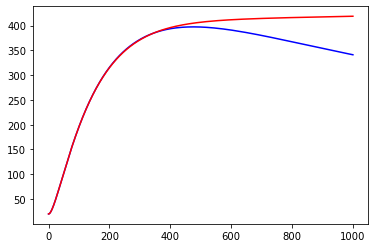

In [8]:
plt.figure(11); plt.plot(T_vero_x0,'b-'); plt.plot(T_vero_x0_corr,'r-'); plt.show()

In [9]:
def validazione(T_vero_x0):
    AIC = []
    MDL = []
    for n in range(1,100,5):
        est_T = calore_1d_fd(Lungh,n,Lungh/n,N,eulero)
        V = 1/N * np.linalg.norm(T_vero_x0-est_T)**2
        AIC.append(np.log(V)+(n+1)*2/N)
        MDL.append(V*(1+(n+1)*np.log(N)/N))
    naic = np.argmin(AIC)*5+2
    plt.plot(AIC); plt.title('Akaike'); plt.show()
    nmdl = np.argmin(MDL)*5+2
    plt.plot(MDL); plt.title('Minimum Description Length'); plt.show()
    print('abbiamo ottenuto, con Akaike e MDL:',naic,'e',nmdl,'rispettivamente')
    print('per ora ho strutturato la funzione perchè restituisca quello ottenuto con Akaike')
    return Lungh/naic

validazione del modello di riferimento e determinazione di Dx:


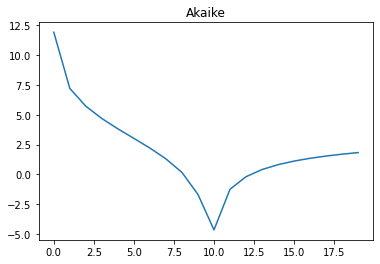

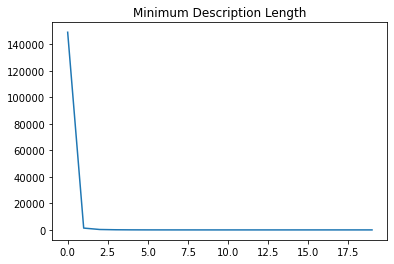

abbiamo ottenuto, con Akaike e MDL: 52 e 52 rispettivamente
per ora ho strutturato la funzione perchè restituisca quello ottenuto con Akaike
Dx =  0.09615384615384616


In [10]:
# 2) analisi della corrosione sulla base dei dati sperimentali
print('validazione del modello di riferimento e determinazione di Dx:')
fid = open("L_sano.pydat","rb")
Lungh = cPickle.load(fid) # contiene la lunghezza "Lungh" del campione sano
#print(Lungh)
Dx = validazione(T_vero_x0)
print('Dx = ',Dx)
fid = open("Dx.pydat","wb")
cPickle.dump(Dx,fid)
fid.close()

In [11]:
def validazione2(T_vero_x0_corr):
    AIC = []
    MDL = []
    for n in range(1,60,3):
        est_T = calore_1d_fd(Dx*n,n,Dx,N,eulero)
        V = 1/N * np.linalg.norm(T_vero_x0_corr-est_T)**2
        AIC.append(np.log(V)+(n+1)*2/N)
        MDL.append(V*(1+(n+1)*np.log(N)/N))
    naic = np.argmin(AIC)*3+1
    plt.plot(AIC); plt.title('Akaike'); plt.show()
    nmdl = np.argmin(MDL)*3+1
    plt.plot(MDL); plt.title('Minimum Description Length'); plt.show()
    print('abbiamo ottenuto, con Akaike e MDL:',naic,'e',nmdl,'rispettivamente')
    print('per ora ho strutturato la funzione perchè restituisca quello ottenuto con Akaike')
    return Dx*naic

In [28]:
calc_FN = lambda r: (np.linalg.norm(r,2) / np.sqrt(len(r)))**2

def GN_LM(y_meas,y,theta_est,stop_iter_thrs_on_applied_coeff_update=0.5,analisi=False,\
             max_iter=20,est_stderrmis=0.0,precision=1):
    N = len(y_meas)
    h_theta = 2
    iteraz = 0 # contatore dell'iterazione
    print("start:  theta_est = ", theta_est, "FN = ", calc_FN(y(theta_est) - y_meas))
    #plt.figure(iteraz); plt.plot(y_meas,'b-'); plt.plot(y(h_theta/2),'r-'); plt.title('iteraz = '+str(iteraz))
    psi_r = np.atleast_2d(np.zeros((N,1)))
    delta_theta_GN = float(np.inf)
    FN = float(np.inf)  # funzione costo (inizialmente ad infinito)
    
    while np.max(np.abs(delta_theta_GN)) > stop_iter_thrs_on_applied_coeff_update and iteraz < max_iter and FN > 1:  
        iteraz += 1
        r = y(theta_est) - y_meas
        FN = calc_FN(r)
        ### Calcolo la matrice di sensitivita' PSI
        y1 = y(theta_est - h_theta/2)                             
        y2 = y(theta_est + h_theta/2) 
        #plt.figure(); plt.plot(y2,'r-'); plt.title('y2='); plt.show()
        #plt.figure(); plt.plot(y1,'b-'); plt.title('y1='); plt.show()
        psi_r = np.atleast_2d((y2 - y1) / h_theta).T
        if analisi:
            print("psi_r = ", psi_r)
            S = np.linalg.svd(psi_r,compute_uv=False)
            print("valori singolari di psi_r = ", S)
        #endif
        #print('psi has a condition number of ',np.linalg.cond(psi_r,2))
        [Q,R] = np.linalg.qr( psi_r )
        delta_theta_GN = np.squeeze( np.linalg.solve(R, -(Q.T @ np.atleast_2d(r).T)) )
        temp_FN = FN
        delta_theta_temp = delta_theta_GN
        mu = 1
        
        while temp_FN >= FN*(9/10) and np.abs(delta_theta_temp) > 0.5: 
            delta_theta_temp = delta_theta_GN * mu
            theta_est_temp = theta_est + delta_theta_temp
            while (theta_est_temp <= 1 or theta_est_temp >= 100) and np.abs(delta_theta_temp) > 0.5:
                mu /= 2.0
                delta_theta_temp = delta_theta_GN * mu
                theta_est_temp = theta_est + delta_theta_temp
            #endwhile
            if theta_est_temp > 1 and theta_est_temp < 100:
                mu /= 2.0
                delta_theta_temp = delta_theta_GN * mu
                theta_est_temp = theta_est + delta_theta_temp
            #endif
            y_temp = y(theta_est_temp)
            temp_FN = calc_FN(y_temp - y_meas)
            #print("FN = ", FN, "temp_FN = ", temp_FN,'delta_theta_temp = ', delta_theta_temp)  
        #endwhile
        if np.abs(delta_theta_temp) > 0.5:
            delta_theta_GN = delta_theta_temp
        else:
            delta_theta_GN = 0
            FN_sx = calc_FN(y(theta_est-1) - y_meas)
            FN_dx = calc_FN(y(theta_est+1) - y_meas)
            if FN < FN_sx and FN > FN_dx:
                print('FN=',FN,'FN_sx=',FN_sx,'FN_dx=',FN_dx)
                return theta_est
            else:
                theta_est = np.random.randint(2,100)
        #endif
        if analisi:
            print("delta_theta_GN = ", delta_theta_GN)
            if est_stderrmis > 0.0:
                print("covarianza err stima dei parametri = ", est_stderrmis * (psi_r.T @ psi_r))
            #endif
        #endif
        theta_est += delta_theta_GN
        r = y(theta_est) - y_meas
        FN = calc_FN(r)
        print("iterazione ", iteraz, ":  theta_est = ", theta_est, "   FN = ", FN)
        #plt.figure(iteraz); plt.plot(y_meas,'b-'); plt.plot(y(theta_est),'r-'); plt.title('iteraz = '+str(iteraz)); #axis([0., 1., -0.5, 0.5])
    #endwhile
    return theta_est

In [35]:
def calore(n):
    n = np.round(n)
    n = int(n)
    if n <= 0:
        print('n è diventato negativo')
    return calore_1d_fd(Dx*n,n,Dx,N,eulero)

def validazione3(T_vero_x0_corr,stima_n=60):
    return Dx*GN_LM(T_vero_x0_corr,calore,stima_n)

In [36]:
Lung = validazione3(T_vero_x0_corr)
print('La lunghezza stimata è di',Lung)

start:  theta_est =  60 FN =  1125.7945225494882
FN =  1125.7945225494882 temp_FN =  866.891879997281 delta_theta_temp =  -23.20087445105713
iterazione  1 :  theta_est =  36.79912554894287    FN =  866.891879997281
FN =  866.891879997281 temp_FN =  173.4603671231756 delta_theta_temp =  -11.605061715669633
iterazione  2 :  theta_est =  25.194063833273233    FN =  173.4603671231756
FN =  173.4603671231756 temp_FN =  59.151779835942705 delta_theta_temp =  -2.6578179720782775
iterazione  3 :  theta_est =  22.536245861194956    FN =  59.151779835942705
FN =  59.151779835942705 temp_FN =  0.9838608541777926 delta_theta_temp =  -1.2651922801497346
iterazione  4 :  theta_est =  21.271053581045223    FN =  0.9838608541777926
La lunghezza stimata è di 2.0452936135620408
